In [2]:
import pydicom
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn.image import resample_to_img
# SOURCE SCRIPTS
#https://github.com/ReubenDo/ReMIND/

## DICOM analysis

In [3]:
def main(id=70):
    # Load the DICOM file

    t1contrast_pre_path = f'../data/ReMIND_dataset/ReMIND-Manifest-Sept-2023/ReMIND/ReMIND-020/12-25-1982-Preop-99162/1.000000-3DAXT1postcontrast-11531/1-0{id}.dcm'
    t1contrast_intra_path = f'../data/ReMIND_dataset/ReMIND-Manifest-Sept-2023/ReMIND/ReMIND-020/12-25-1982-Intraop-24150/6.000000-3DAXT1postcontrast-64739/1-0{id}.dcm'
    tumor_path = '../data/ReMIND_dataset/ReMIND-Manifest-Sept-2023/ReMIND/ReMIND-020/12-25-1982-Preop-99162/303.000000-tumor seg - MR ref 3DAXT1postcontrast-97101/1-1.dcm'
    t1_contrast_pre_dicom = pydicom.dcmread(t1contrast_pre_path)
    t1_contrast_intra_dicom = pydicom.dcmread(t1contrast_intra_path)
    tumor_dicom = pydicom.dcmread(tumor_path)
    return t1_contrast_pre_dicom, t1_contrast_intra_dicom, tumor_dicom

In [4]:
pre, post, tumor = main(63)
plt.imshow(tumor.pixel_array[:, :, 33], cmap='jet', alpha=0.9)  # Overlay the 'tumor' with transparency

plt.imshow(pre.pixel_array, cmap='gray')  # Display the grayscale 'pre' image

plt.axis('off')  # Remove axis
plt.show()  # Display both images

FileNotFoundError: [Errno 2] No such file or directory: '../data/ReMIND_dataset/ReMIND-Manifest-Sept-2023/ReMIND/ReMIND-020/12-25-1982-Preop-99162/1.000000-3DAXT1postcontrast-11531/1-063.dcm'

In [5]:
tumor.keys()

dict_keys([(0008,0005), (0008,0008), (0008,0016), (0008,0018), (0008,0020), (0008,0021), (0008,0023), (0008,0030), (0008,0031), (0008,0033), (0008,0050), (0008,0060), (0008,0070), (0008,0090), (0008,1030), (0008,103E), (0008,1090), (0010,0010), (0010,0020), (0010,0030), (0010,0040), (0012,0050), (0012,0060), (0012,0062), (0012,0063), (0012,0064), (0012,0071), (0013,0010), (0013,1010), (0013,1013), (0018,0015), (0018,1000), (0018,1020), (0020,000D), (0020,000E), (0020,0010), (0020,0011), (0020,0013), (0020,0052), (0020,1040), (0020,9221), (0020,9222), (0028,0002), (0028,0004), (0028,0008), (0028,0010), (0028,0011), (0028,0100), (0028,0101), (0028,0102), (0028,0103), (0028,0303), (0028,2110), (0062,0001), (0062,0002), (0062,0013), (0070,0080), (0070,0081), (0070,0084), (5200,9229), (5200,9230), (7FE0,0010)])

In [6]:
tumor

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 208
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: Segmentation Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.271595585736519184579299251692387669458
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002,0013) Implementation Version Name         SH: '0.5'
(0002,0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['DERIVED', 'PRIMARY']
(0008,0016) SOP Class UID                       UI: Segmentation Storage
(0008,0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.271595585736519184579299251692

In [7]:
pre.ImagePositionPatient
#pre['0020,0032']

[39.7105, -244.872, 57.4417]

### REMIND CONVERT BY https://github.com/ReubenDo/ReMIND/ is skipped, no tumor segmentations
### Using our own /scripts/preprocessing/remind/dcm2niix conversion, using dcm2niix and segimage2itkimage to convert to NIFTI whilst perserving alignment

In [11]:
import nibabel as nib
import numpy as np
def reorient_to_standard(image):
    # Get the current orientation as axis codes
    current_orientation = nib.aff2axcodes(image.affine)
    print(f"Current orientation: {current_orientation}")

    # Define the desired orientation (RAS)
    desired_orientation = ('R', 'A', 'S')

    # Convert axis codes to orientation arrays
    current_ornt = nib.orientations.axcodes2ornt(current_orientation)
    desired_ornt = nib.orientations.axcodes2ornt(desired_orientation)

    # Get the orientation transform
    ornt_transform = nib.orientations.ornt_transform(current_ornt, desired_ornt)

    # Apply the orientation transform
    reoriented_data = nib.orientations.apply_orientation(image.get_fdata(), ornt_transform)
    reoriented_affine = nib.orientations.inv_ornt_aff(ornt_transform, image.shape)
    reoriented_affine = np.dot(image.affine, reoriented_affine)

    # Create a new NIfTI image with the reoriented data and affine
    reoriented_image = nib.Nifti1Image(reoriented_data, reoriented_affine)

    # Check the new orientation
    new_orientation = nib.aff2axcodes(reoriented_image.affine)
    print(f"New orientation: {new_orientation}")

    return reoriented_image

In [29]:
import nibabel as nib
from nilearn.image import resample_to_img
pre_nifti  = nib.load('../data/ReMIND_dataset/ReMIND-Manifest-Sept-2023/ReMIND/ReMIND-020/12-25-1982-Intraop/T1_converted/6.000000-3DAXT1postcontrast-64739_3D_AX_T1_postcontrast_19821225171237_6.nii.gz')
post_nifti = nib.load('../data/ReMIND_dataset/ReMIND-Manifest-Sept-2023/ReMIND/ReMIND-020/12-25-1982-Preop/T1_converted/1.000000-3DAXT1postcontrast-11531_3D_AX_T1_postcontrast_19821225171232_1.nii.gz')
tumor_nifti = nib.load('../data/ReMIND_dataset/ReMIND-Manifest-Sept-2023/ReMIND/ReMIND-020/12-25-1982-Preop/tumor_converted/1.nii.gz')
pre_nifti1 = reorient_to_standard(pre_nifti)
print("\n post  ", np.where(pre_nifti.get_fdata() == pre_nifti1.get_fdata()))
post_resample = resample_to_img(source_img=post_nifti, target_img=pre_nifti1, interpolation='nearest')
tumor_resample = resample_to_img(source_img=tumor_nifti, target_img=pre_nifti1, interpolation='nearest')

pre = pre_nifti.get_fdata()
post = post_resample.get_fdata()
tumor = tumor_resample.get_fdata()
# print("pre ", pre_nifti.header)
# print("\n post  ", post_resample.header)
# print("\n ")
# print("tumor " , tumor_resample.header)

Current orientation: ('L', 'A', 'S')
New orientation: ('R', 'A', 'S')

 post   (array([  0,   0,   0, ..., 255, 255, 255]), array([  0,   0,   0, ..., 255, 255, 255]), array([  0,   1,   2, ..., 173, 174, 175]))


In [30]:
print(nib.aff2axcodes(pre_nifti.affine))
print(nib.aff2axcodes(post_resample.affine))
print(nib.aff2axcodes(tumor_resample.affine))


('L', 'A', 'S')
('R', 'A', 'S')
('R', 'A', 'S')


In [31]:
print(pre.shape, post.shape, tumor.shape)
print(pre_nifti.affine)
print(post_nifti.affine)
print(tumor_nifti.affine)

(256, 256, 176) (256, 256, 176) (256, 256, 176)
[[-8.76537025e-01  4.81312126e-01 -5.49262203e-03  5.01014099e+01]
 [ 4.81314003e-01  8.76373231e-01 -2.10370999e-02 -8.99381714e+01]
 [ 4.42653988e-03  1.75696034e-02  1.19980037e+00 -8.62670441e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 8.39540124e-01  4.89537895e-01  9.81967226e-02 -1.70631866e+02]
 [-4.92123127e-01  8.43494892e-01  2.49832356e-03  2.96257935e+01]
 [ 8.16189498e-02  5.04306480e-02 -9.94996965e-01  1.06282181e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-8.36110234e-01 -4.97573167e-01 -8.57658684e-02  3.29667044e+00]
 [ 4.98320371e-01 -8.39733958e-01  1.44071067e-02  1.14584480e+02]
 [-7.91891068e-02 -3.06929499e-02  9.96211171e-01  1.64463341e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


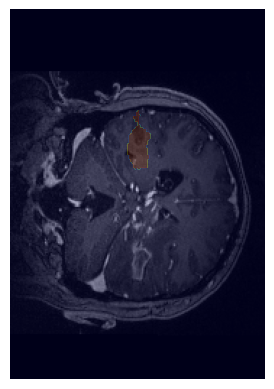

In [32]:
plt.imshow(pre_nifti.get_fdata()[:, 100, :], cmap='gray', alpha=1)  # Overlay the 'tumor' with transparency
# plt.imshow(pre[140], cmap='jet', alpha=0.2)  # Display the grayscale 'pre' image
plt.imshow(tumor[:, 100, :], cmap='jet', alpha=0.2)  # Overlay the 'tumor' with transparency
plt.axis('off')  # Remove axis
plt.show()  # Display both images

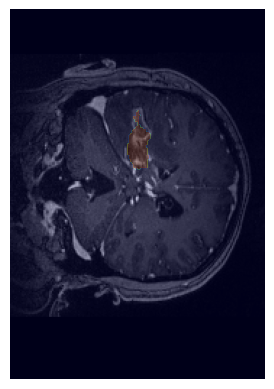

In [34]:
plt.imshow(pre_nifti1.get_fdata()[:, 100, :], cmap='gray', alpha=1)  # Overlay the 'tumor' with transparency
# plt.imshow(pre[140], cmap='jet', alpha=0.2)  # Display the grayscale 'pre' image
plt.imshow(tumor[:, 100, :], cmap='jet', alpha=0.2)  # Overlay the 'tumor' with transparency
plt.axis('off')  # Remove axis
plt.show()  # Display both images

## Check skull extraction params

In [6]:
pat_103path = "/home/adil/Documents/TUE/preparationPhase/myProject/data/ReMIND_dataset/ReMIND-Manifest-Sept-2023/ReMIND/ReMIND-103/12-25-1982-Preop-65502/T1_converted/2.000000-3DAXT1postcontrast-38037_3D_AX_T1_postcontrast_19821225152927_2.nii.gz"
pat103skull = nib.load(pat_103path)
print(pat103skull.get_fdata().shape)
plt.imshow(pat103skull.get_fdata()[:, 120, :].T, cmap='gray', alpha=1)  # Overlay the 'tumor' with transparency

FileNotFoundError: No such file or no access: '/home/adil/Documents/TUE/preparationPhase/myProject/data/ReMIND_dataset/ReMIND-Manifest-Sept-2023/ReMIND/ReMIND-103/12-25-1982-Preop-65502/T1_converted/2.000000-3DAXT1postcontrast-38037_3D_AX_T1_postcontrast_19821225152927_2.nii.gz'

42


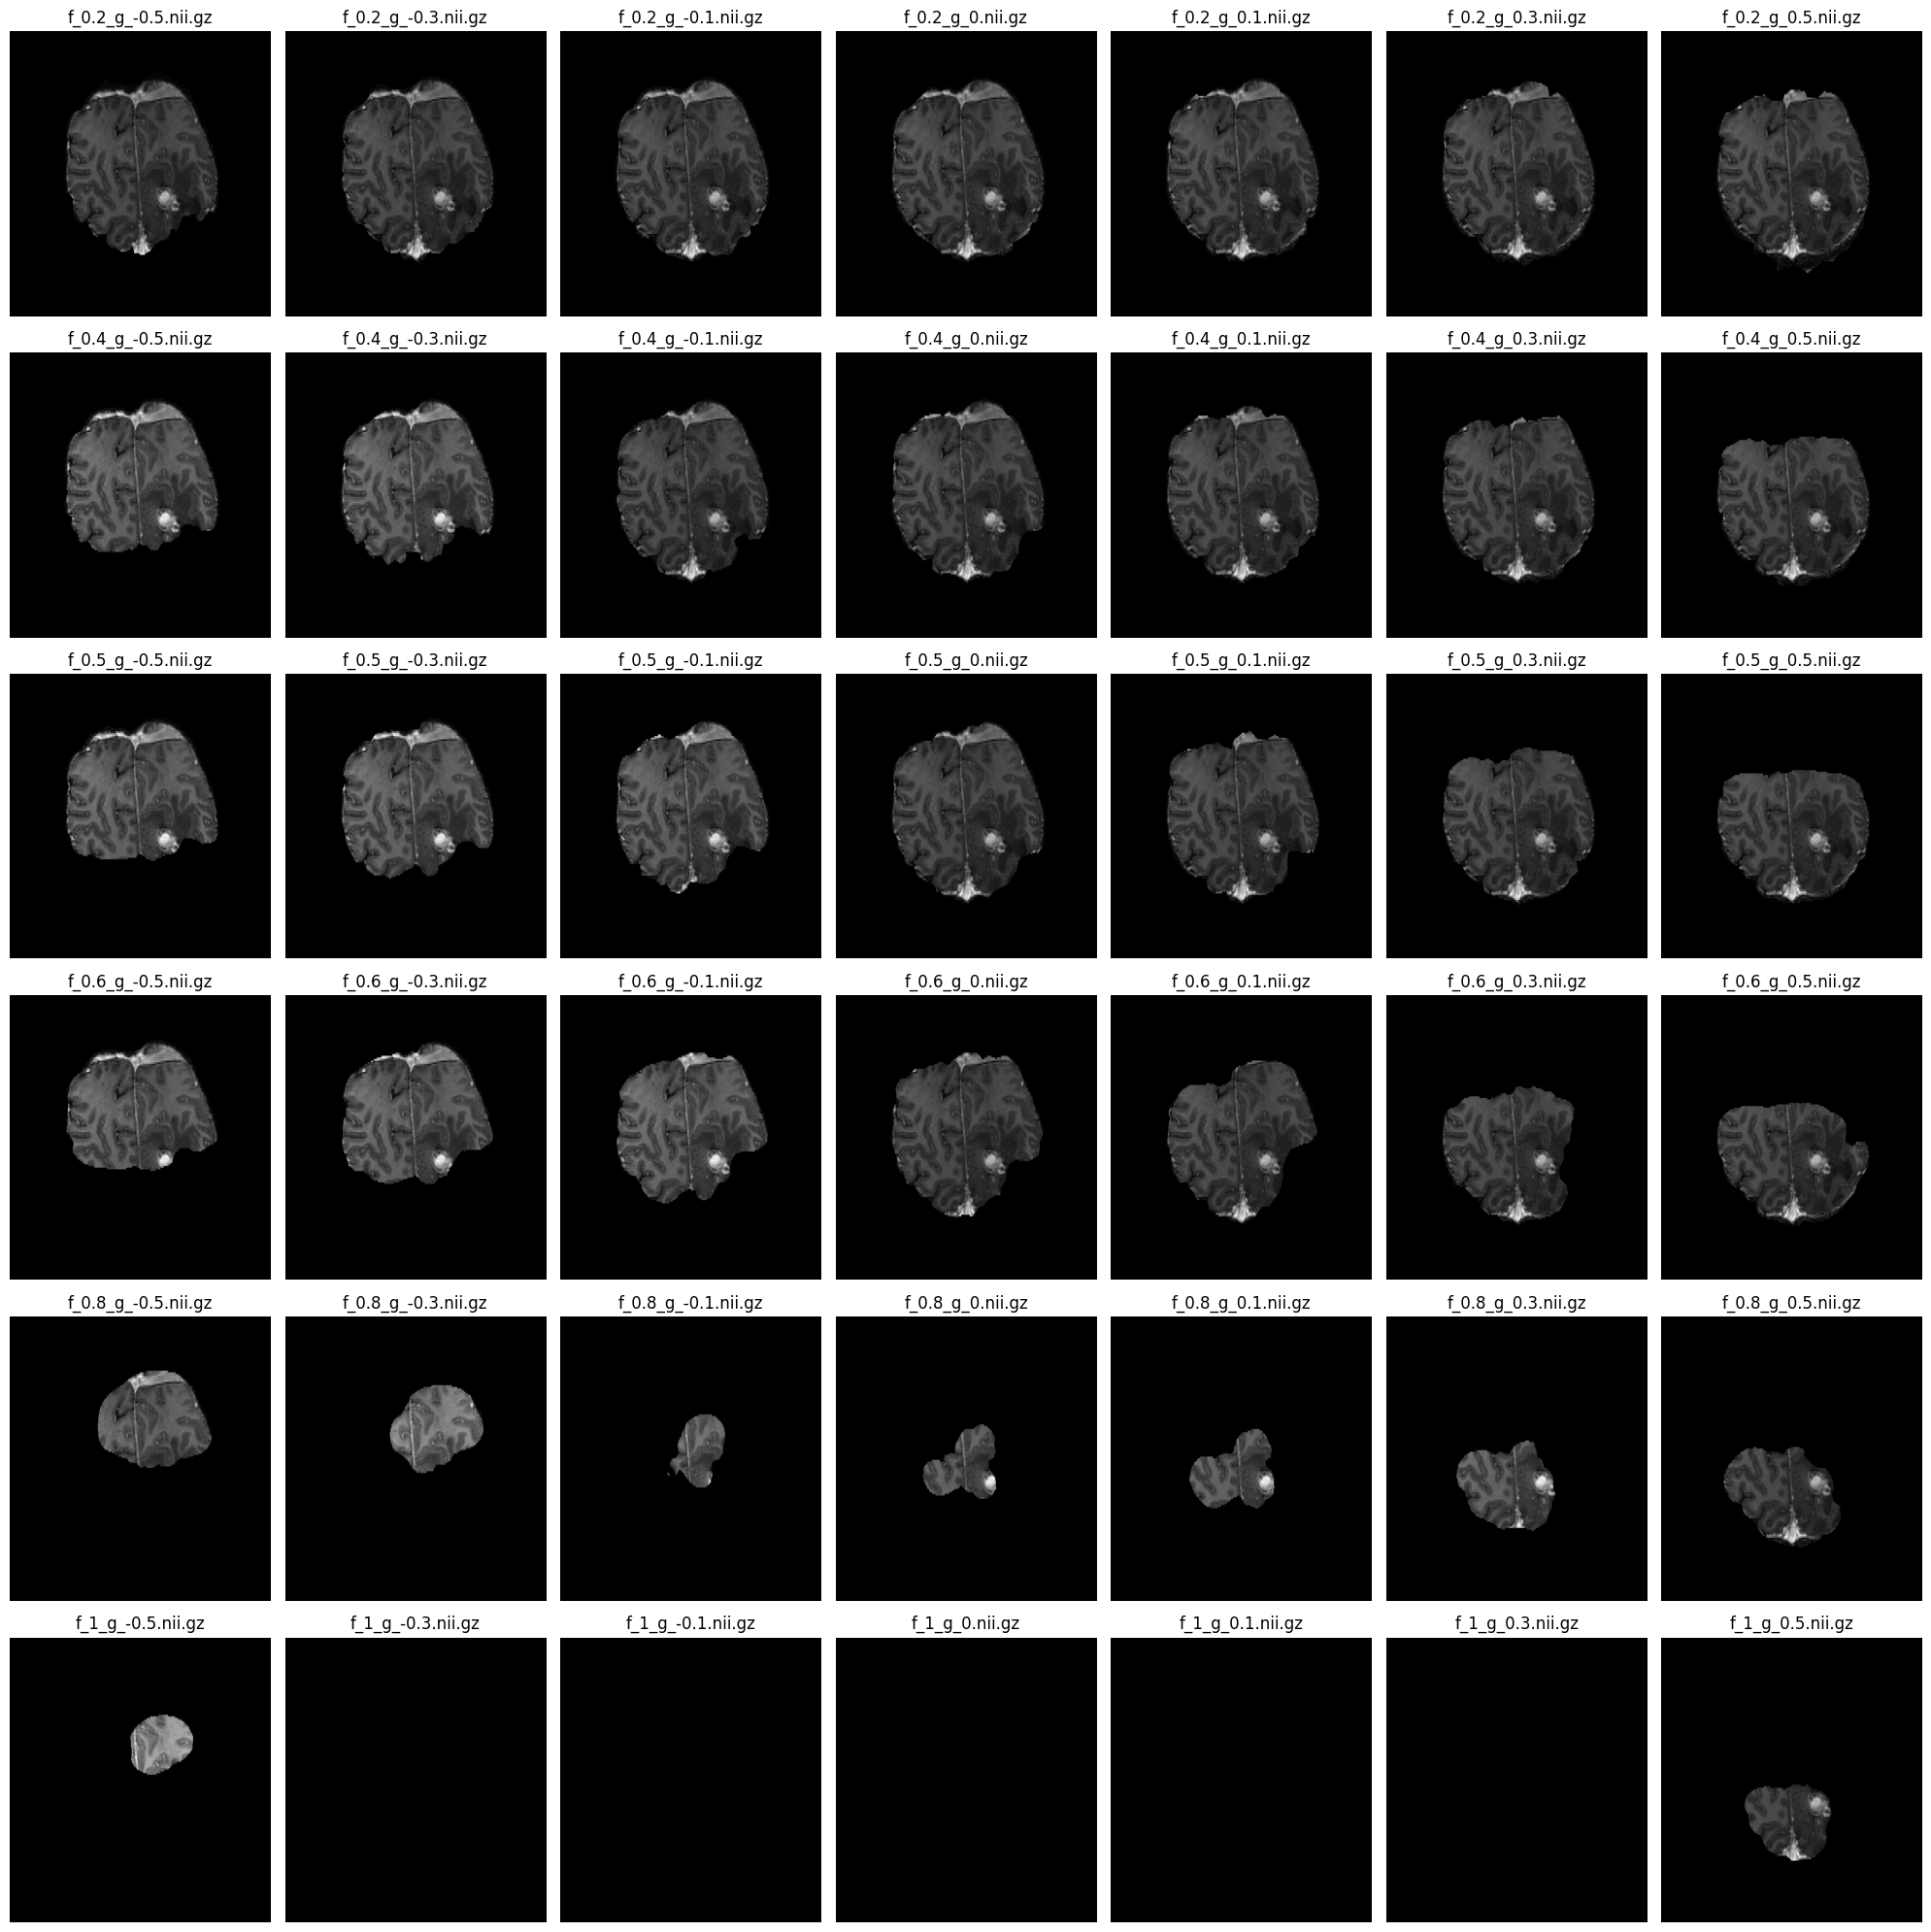

In [7]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import re
folder_extracted = "/home/adil/Documents/TUE/preparationPhase/myProject/data/ReMIND_dataset/ReMIND-Manifest-Sept-2023/ReMIND/ReMIND-103/12-25-1982-Preop/T1_converted/bet_outputs"
files = [file for file in os.listdir(folder_extracted) if file.endswith(".nii.gz")]
num_files = len(files)
print(num_files)
# Define a function to extract f and g values from the filename and convert them to floats
def extract_f_g(filename):
    match = re.search(r'f_([-+]?\d*\.\d+|\d+)_g_([-+]?\d*\.\d+|\d+)', filename)
    if match:
        f = float(match.group(1))
        g = float(match.group(2))
        return (f, g)
    else:
        print(f"Pattern not found in {filename}")
    return (0.0, 0.0)  # Default values if pattern not found

# Extract keys for sorting
keys = [(extract_f_g(file), file) for file in files]
sorted_files = [file for _, file in sorted(keys)]
# Sort files based on the extracted f and g values

num_cols = 7
num_rows = (num_files + num_cols - 1) // num_cols  # Ceiling division

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

for i, file in enumerate(sorted_files):
    file_path = os.path.join(folder_extracted, file)
    nifti = nib.load(file_path)
    data = nifti.get_fdata()
    
    # Assuming you want to visualize the middle slice of the first axis
    slice = data[:, 120, :]
    
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    ax.imshow(slice.T, cmap="gray", origin="lower", aspect='auto')
    ax.set_title(file)
    ax.axis('off')

# Hide any unused subplots
for j in range(num_files, num_rows * num_cols):
    row = j // num_cols
    col = j % num_cols
    axes[row, col].axis('off')
plt.tight_layout()
plt.savefig("/home/adil/Downloads/output_bet.png")
plt.show()

### lets now work with the BET'd niftis

In [8]:
pre_nifti  = nib.load('../data/ReMIND_dataset/ReMIND-Manifest-Sept-2023/ReMIND/ReMIND-020/12-25-1982-Preop/T1_converted/t1_aligned_stripped.nii.gz')
post_nifti = nib.load('../data/ReMIND_dataset/ReMIND-Manifest-Sept-2023/ReMIND/ReMIND-008/12-25-1982-Intraop/T1_converted/t1_aligned_stripped.nii.gz')
tumor_nifti = nib.load('../data/ReMIND_dataset/ReMIND-Manifest-Sept-2023/ReMIND/ReMIND-020/12-25-1982-Preop/tumor_converted/1.nii.gz')

post_resample = resample_to_img(source_img=post_nifti, target_img=pre_nifti, interpolation='nearest')
tumor_resample = resample_to_img(source_img=tumor_nifti, target_img=pre_nifti, interpolation='nearest')

pre = pre_nifti.get_fdata()
post = post_resample.get_fdata()
tumor = tumor_resample.get_fdata()
print("pre ", pre_nifti.header)
print("\n post  ", post_resample.header)
print("\n ")
print("tumor " , tumor_resample.header)

pre  <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 224 256 192   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.          0.9765626   0.9765625   0.99983394  0.          0.
  0.          0.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'2203.11-dirty 2023-08-23T14:21:21+01:00'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.014037737
quatern_c       : -0.047136016
quatern_d  

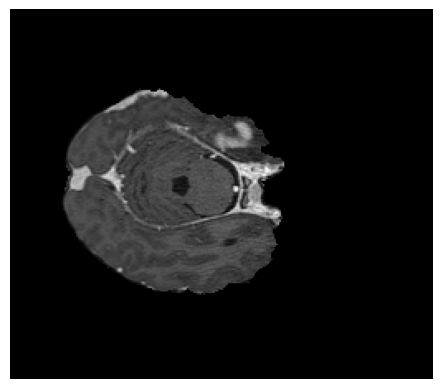

In [23]:
import numpy as np
plt.imshow(pre[:, :, 120], cmap='gray', alpha=1)  # Overlay the 'tumor' with transparency
# plt.imshow(pre[140], cmap='jet', alpha=0.2)  # Display the grayscale 'pre' image
# plt.imshow(tumor[:, 164, :], cmap='jet', alpha=0.2)  # Overlay the 'tumor' with transparency
plt.axis('off')  # Remove axis
plt.show()  # Display both images